In [ ]:
# !pip install black[jupyter]
# !pip install --upgrade autopep8
# !black /content/drive/MyDrive/Colab Notebooks/Copy of Image Captioning v23.05.03.ipynb

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Import Libraries

In [ ]:
import string
import os
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import vgg16
from keras.models import Model, load_model
import keras.preprocessing.sequence as kps
from keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.image as mpimg
from PIL import Image

from keras.layers import Input, Dense, Dropout, Add, Embedding, GRU
from keras.models import Model

import pickle

%matplotlib inline

# Mount Drive

In [ ]:
# Mount the Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Download Dataset

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

# Define Constants

In [ ]:
text_folder = "/content/"
img_folder = "Flicker8k_Dataset"
pretrained_input_size = 224
key = "Inception_LSTM_GRU"
drive_path = f"drive/MyDrive/{key}"

glove_embed_path = os.path.join(drive_path, "glove.6B.50d.txt")
captions_path = os.path.join(text_folder, "Flickr8k.token.txt")
encodings_train_file_path = os.path.join(drive_path, "encoded_train_images.pkl")
encodings_test_file_path = os.path.join(drive_path, "encoded_test_images.pkl")
final_model_path = os.path.join(drive_path, "weights")

# Text Modules

In [ ]:
def load_text(filename):
    """
    Load text from a file and return it as a list of strings.

    Inputs:
    - filename: The name of the file to load.

    Returns:
    - text: A list of strings representing the lines in the file.
    """
    # open the file as read only
    file = open(filename, "r")
    # read all text
    text = file.read()
    text = text.split("\n")
    # close the file
    file.close()
    return text

In [ ]:
def caption_generator(photo, model, max_length, wordtoix, ixtoword):
    """
    Generate a caption for a given image using the specified model and vocabulary.

    Inputs:
    - photo: A numpy array representing the image.
    - model: A trained Keras model for generating captions.
    - max_length: The maximum length of the generated caption.
    - wordtoix: A dictionary mapping words to integer indices.
    - ixtoword: A dictionary mapping integer indices to words

    Returns:  A list of strings representing the generated caption, including the "startseq" and "endseq" tokens.
    
    """
    # start with 'startseq'
    in_text = ["startseq"]
    # iterate over the maximal length of description
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = tf.pad(
            seq,
            paddings=[[max_length - len(seq), 0]],
            mode="CONSTANT",
            constant_values=0,
        )
        in_put = [np.array([photo]), np.array([seq])]
        out_word = model.predict(in_put, verbose=0)
        # convert probability to integer
        out_word = np.argmax(out_word)
        # map ix to word
        out_word = ixtoword[out_word]
        # stop if we cannot map the word
        if out_word is None:
            break
        # append as input for generating the next word
        in_text.append(out_word)
        # stop if we predict the end of the sequence
        if out_word == "endseq":
            break
    return in_text

In [ ]:
def load_descriptions(doc):
    """
    Load image descriptions from a text file and return them as a dictionary.

    Inputs:
    - doc: A list of strings representing the lines in the file.

    Returns:
    - mapping: A dictionary mapping image ids to their corresponding descriptions.
    """
    
    mapping = dict()
    # process lines
    for line in doc:
        # split line by white space
        tokens = line.split()
        if len(tokens) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split(".")[0]
        # convert description tokens back to string
        # add 'startseq' and 'endseq' to each description
        image_desc = "startseq " + " ".join(image_desc) + " endseq"
        # store the first description for each image
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping

In [ ]:
def clean_description(desc_dict):
    """
    Function:
      Takes a dictionary of image descriptions as input, 
      Preprocesses the text by removing punctuation,
      Converts all words to lowercase, 
      Removes words with length less than or equal to one, 
      and joins the words back into a string. 
    The function modifies the input dictionary in place.

    Inputs:
    - desc_dict: a dictionary of image descriptions, where the keys are image IDs and the values are lists
      of descriptions for each image.

    Returns: None
    """
    # prepare translation table for removing punctuation
    table = str.maketrans("", "", string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word) > 1]
            # store as string
            desc_list[i] = " ".join(desc)

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions, keys):
    all_desc = list()
    for key in keys:
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions, keys):
    lines = to_lines(descriptions, keys)
    return max(len(d.split()) for d in lines)

In [ ]:
descriptions = load_text(captions_path)
desc_dict = load_descriptions(descriptions)
clean_description(desc_dict)

In [ ]:
print(desc_dict["997722733_0cb5439472"])

['startseq man in pink shirt climbs rock face endseq', 'startseq man is rock climbing high in the air endseq', 'startseq person in red shirt climbing up rock face covered in assist handles endseq', 'startseq rock climber in red shirt endseq', 'startseq rock climber practices on rock climbing wall endseq']


# Image Modules

# Load Dataset

In [ ]:
train_imgs = load_text(os.path.join(text_folder, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(text_folder, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(text_folder, "Flickr_8k.devImages.txt"))
train_imgs = [x for x in train_imgs if x != ""]
test_imgs = [x for x in test_imgs if x != ""]
dev_imgs = [x for x in dev_imgs if x != ""]

In [ ]:
train_set_length = len(train_imgs)
test_set_length = len(test_imgs)
dev_set_length = len(dev_imgs)

In [ ]:
print(train_set_length)
print(test_set_length)
print(dev_set_length)

6000
1000
1000


## Data Visualization

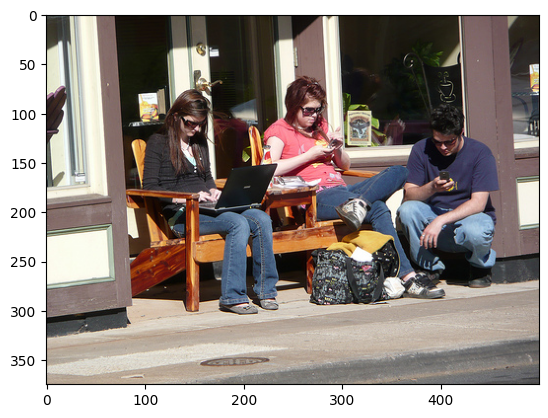

In [ ]:
image1 = train_imgs[32]
imagepath = os.path.join(text_folder, img_folder, image1)
image_1 = Image.open(imagepath)
plt.imshow(image_1)

# Image Pretrained Model

In [ ]:
with open(encodings_file_path, "rb") as file:
    encoded_train_images = pickle.load(file)

print("Loaded variable:", len(encoded_train_images))

Loaded variable: 6000


In [ ]:
with open(encodings_test_file_path, "rb") as file:
    encoded_test_images = pickle.load(file)

print("Loaded variable:", len(encoded_test_images))

Loaded variable: 1000


In [ ]:
def get_features(img_folder, img_name, model, in_size):
    # Convert all the images to size 299x299 as expected
    img = Image.open(os.path.join(img_folder, img_name))
    size = (in_size, in_size)
    img = img.resize(size)
    # Convert PIL image to numpy array of 3-dimensions
    x = np.asarray(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)
    x = model.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x

In [ ]:
# Get the InceptionV3 model trained on imagenet data
pretrained_model = InceptionV3(weights="imagenet")

# Remove the last layer (output softmax layer) from the inception v3
pretrained_model = Model(pretrained_model.input, pretrained_model.layers[-2].output)

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
encoded_train_images = {}
for i in range(0, train_set_length):
    encoded_train_images[train_imgs[i].split(".")[0]] = get_features(
        os.path.join(text_folder, img_folder),
        train_imgs[i],
        pretrained_model,
        pretrained_input_size,
    )

In [ ]:
# Set the file path to save the file on the desktop
# Save the variable using pickle.dump()
with open(encodings_file_path, "wb") as file:
    pickle.dump(encoded_train_images, file)

print("Variable saved to:", encodings_file_path)

In [ ]:
encoded_test_images = {}
for i in range(0, test_set_length):
    if i % 1000 == 0:
        print(i)
    encoded_test_images[test_imgs[i].split(".")[0]] = get_features(
        os.path.join(text_folder, img_folder),
        test_imgs[i],
        pretrained_model,
        pretrained_input_size,
    )

In [ ]:
with open("encoded_train_images.pkl", "wb") as file:
    pickle.dump(encoded_train_images, file)

print("Variable saved to:", encodings_test_file_path)

In [ ]:
# Set the file path to save the file on the desktop
# Save the variable using pickle.dump()
with open("encoded_test_images.pkl", "wb") as file:
    pickle.dump(encoded_test_images, file)

print("Variable saved to:", encodings_test_file_path)

In [ ]:
train_keys = []
for i in range(0, train_set_length):
    train_keys.append(train_imgs[i].split(".")[0])
len(train_keys)

6000

In [ ]:
test_keys = []
for i in range(0, test_set_length):
    test_keys.append(test_imgs[i].split(".")[0])
len(test_keys)

1000

In [ ]:
# Create the vocabulary.
embedding_dim = 200

vocabulary = set()
for key in desc_dict.keys():
    [vocabulary.update(d.split()) for d in desc_dict[key]]
vocabulary = list(vocabulary)
print("Original Vocabulary Size: %d" % len(vocabulary))
# Create the word <--> index mappers.
# NOTE: index starts from 1, not 0.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1


# Load Glove vectors
embeddings_index = {}  # empty dictionary
f = open(glove_embed_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Volcabulary size of GLOVE: {}".format(len(embeddings_index)))
# Get 200-dim dense vector for each of words in vocabulary

vocab_size = len(vocabulary) + 1  # added 1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

print(
    "Shape of embedding weights for the current vocabulary {}".format(
        embedding_matrix.shape
    )
)

Original Vocabulary Size: 8810
Volcabulary size of GLOVE: 400000
Shape of embedding weights for the current vocabulary (8811, 200)


# Data Loader

In [ ]:
# define the data generator function
def data_generator(
    descriptions, img_keys, photos, wordtoix, max_length, num_photos_per_batch
):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            if key in img_keys:
                n += 1
                # retrieve the photo feature
                photo = photos[key]
                for desc in desc_list:
                    # encode the sequence
                    seq = [
                        wordtoix[word] for word in desc.split(" ") if word in wordtoix
                    ]
                    # split one sequence into multiple X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pair
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = tf.pad(
                            in_seq,
                            paddings=[[max_length - len(in_seq), 0]],
                            mode="CONSTANT",
                            constant_values=0,
                        )
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        # store
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
                # yield the batch data
                if n == num_photos_per_batch:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    X1, X2, y = list(), list(), list()
                    n = 0

In [ ]:
train_max_len = max_length(desc_dict, train_keys)
print("Max Description Length: %d" % train_max_len)


train_generator = data_generator(
    descriptions=desc_dict,
    img_keys=train_keys,
    photos=encoded_train_images,
    wordtoix=wordtoix,
    max_length=train_max_len,
    num_photos_per_batch=32,
)

train_inputs, train_outputs = next(train_generator)
print(train_inputs[0].shape)
print(train_inputs[1].shape)
print(train_outputs.shape)

Max Description Length: 34
(1754, 2048)
(1754, 34)
(1754, 8811)


In [ ]:
val_max_len = max_length(desc_dict, test_keys)
print("Max Description Length: %d" % val_max_len)

validation_generator = data_generator(
    descriptions=desc_dict,
    img_keys=test_keys,
    photos=encoded_test_images,
    wordtoix=wordtoix,
    max_length=val_max_len,
    num_photos_per_batch=32,
)

val_inputs, val_outputs = next(validation_generator)
print(val_inputs[0].shape)
print(val_inputs[1].shape)
print(val_outputs.shape)

Max Description Length: 30
(1685, 2048)
(1685, 30)
(1685, 8811)


# Model Architecture

In [ ]:
dropout = 0.1

# Define input layers
image_input = Input(shape=(2048,))
text_input = Input(shape=(train_max_len,))

# Image feature extractor
x = Dropout(dropout)(image_input)
x = Dense(256, activation="relu")(x)
x = Dropout(dropout)(x)
x = Dense(256, activation="relu")(x)

# Text feature extractor
y = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
y = Dropout(dropout)(y)
y = LSTM(256, return_sequences=True)(y)
y = GRU(256)(y)

# Merge image and text features
merged = Add()([x, y])
merged = Dense(256, activation="relu")(merged)

# Output layer
outputs = Dense(vocab_size, activation="softmax")(merged)

# Define the model
model = Model(inputs=[image_input, text_input], outputs=outputs)

# Set embedding layer weights and freeze the layer
# model.layers[2].set_weights([embedding_matrix])
# model.layers[2].trainable = False

# Compile the model with sparse categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1762200     ['input_3[0][0]']                
                                                                                            

## Model Callbacks

In [ ]:
checkpoint = ModelCheckpoint(
    model, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

earlystopping = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss", patience=3, verbose=1, factor=0.2, min_lr=0.00001
)

In [ ]:
epochs = 10
num_photos_per_batch = 32
steps = len(desc_dict) // num_photos_per_batch
train_loss = []
val_loss = []

for ep in range(epochs):
    print("run epoch {}".format(ep + 1))
    history = model.fit(train_generator, steps_per_epoch=steps, epochs=1)
    val_loss.append(model.evaluate(validation_generator, steps=steps))
    train_loss.append(history.history["loss"][0])
    model.save(
        os.path.join(
            "/content/drive/MyDrive",
            "inception_lstm_gru",
            "trained_model_{}epochs.h5".format(ep),
        )
    )

run epoch 0
252/252 [==============================] - 180s 716ms/step - loss: 3.9814
run epoch 1
252/252 [==============================] - 176s 700ms/step - loss: 3.8637
run epoch 2
252/252 [==============================] - 183s 728ms/step - loss: 3.8322
run epoch 3
252/252 [==============================] - 178s 710ms/step - loss: 3.8308
run epoch 4
252/252 [==============================] - 178s 707ms/step - loss: 3.8812
run epoch 5
252/252 [==============================] - 178s 709ms/step - loss: 3.9242
run epoch 6
252/252 [==============================] - 179s 711ms/step - loss: 3.9629
run epoch 7
252/252 [==============================] - 181s 720ms/step - loss: 4.0872
run epoch 8
252/252 [==============================] - 179s 712ms/step - loss: 4.1010
run epoch 9
252/252 [==============================] - 177s 704ms/step - loss: 4.2515


In [ ]:
# Delete after run 05/05/2023

epochs = 1
num_photos_per_batch = 32
steps = len(desc_dict) // num_photos_per_batch
train_loss = []
val_loss = []

for ep in range(epochs):
    print("run epoch {}".format(ep + 1))
    history = model.fit(train_generator, steps_per_epoch=steps, epochs=1)
    val_loss.append(model.evaluate(validation_generator, steps=steps))
    train_loss.append(history.history["loss"][0])
    model.save(
        os.path.join(
            "/content/drive/MyDrive",
            "inception_lstm_gru",
            "trained_model_{}epochs.h5".format(ep),
        )
    )

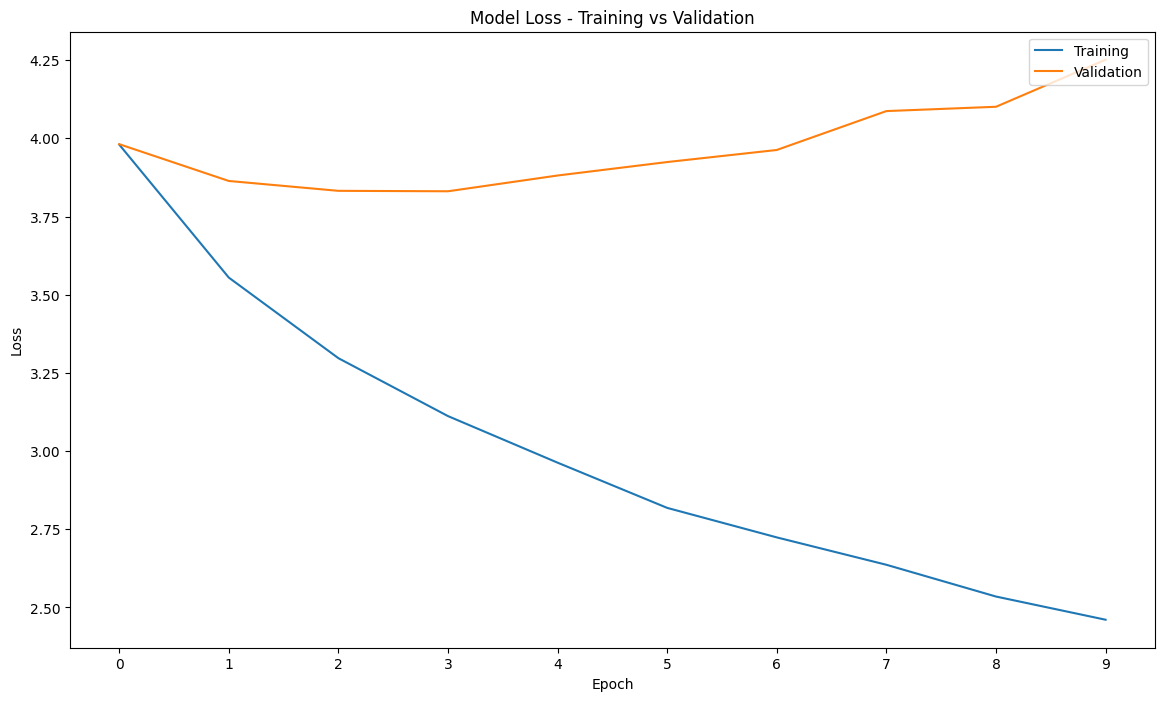

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Model Loss - Training vs Validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(range(10))
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

# BLEU SCORE

In [ ]:
predicted_captions = []
for i in range(test_set_length):
    encoded_inp = encoded_test_images[test_imgs[i].split(".")[0]]
    pred = caption_generator(
        photo=encoded_inp,
        model=model,
        max_length=train_max_len,
        wordtoix=wordtoix,
        ixtoword=ixtoword,
    )
    predicted_captions.append(pred)
predicted_captions[1:5]

In [ ]:
actual_captions = []
for i in test_imgs:
    actual_captions.append(desc_dict[i.split(".")[0]])
len(actual_captions)

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu


def remove_tokens(caption):
    caption = caption.replace("startseq ", "")
    caption = caption.replace(" endseq", "")
    return caption


def findBleuScore(predicted_captions, ground_truth_captions):
    captions = []

    for caption in predicted_captions:
        readable_caption = " ".join(caption)
        captions.append(readable_caption)

    readable_captions = [remove_tokens(caption) for caption in captions]
    predicted_captions = readable_captions

    # Tokenize the predicted captions
    tokenized_predicted_captions = [caption.split() for caption in predicted_captions]

    # Remove 'startseq' and 'endseq' and tokenize the ground truth captions
    tokenized_ground_truth_captions = []

    for image_captions in ground_truth_captions:
        image_captions_tokenized = [caption.split()[1:-1] for caption in image_captions]
        tokenized_ground_truth_captions.append(image_captions_tokenized)

    # Compute the BLEU scores
    bleu1 = corpus_bleu(tokenized_ground_truth_captions, tokenized_predicted_captions, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(tokenized_ground_truth_captions, tokenized_predicted_captions, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(tokenized_ground_truth_captions, tokenized_predicted_captions, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(tokenized_ground_truth_captions, tokenized_predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))
    
    print("BLEU-1 score: ", bleu1)
    print("BLEU-2 score: ", bleu2)
    print("BLEU-3 score: ", bleu3)
    print("BLEU-4 score: ", bleu4)


findBleuScore(predicted_captions, actual_captions)

# Inference

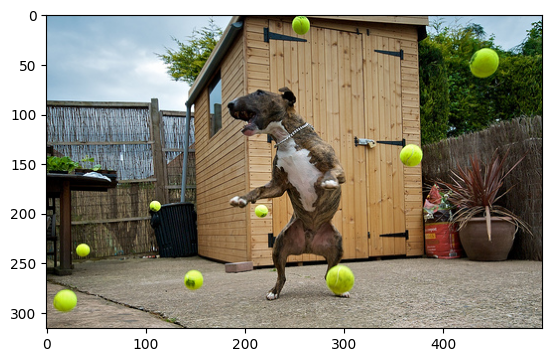

1/1 [==============================] - 0s 31ms/step
Predicted Caption: dog catching tennis ball in the yellow dog

Actual Captions
 big dog stands on his hand leg as tennis balls are thrown his direction 
 brown and white dog in front of shed overwhelmed by the onslaught of tennis balls 
 brown and white dogs stands in front of wooden building while tennis balls fly through the air 
 dog jumps for several tennis balls thrown at him 
 dog stands on his hind legs amid shower of tennis balls 


In [ ]:
for i in [999]:
    image1 = test_imgs[i]
    imagepath = os.path.join(img_folder, image1)
    image_1 = Image.open(imagepath)
    plt.imshow(image_1)
    plt.show()

    encoded_inp = get_features(
        img_folder, test_imgs[i], pretrained_model, pretrained_input_size
    )
    pred = caption_generator(
        photo=encoded_inp,
        model=model,
        max_length=val_max_len,
        wordtoix=wordtoix,
        ixtoword=ixtoword,
    )

    print(f"Predicted Caption: {' '.join(pred[1:-1])}")

    print("\nActual Captions")
    for capt in desc_dict[test_imgs[i].split(".")[0]]:
        print(capt.replace("startseq", "").replace("endseq", ""))

    # BLEU Score
    act_cap = [actual_captions[i]]
    findBleuScore([pred],act_cap)

## Using optimal model weights (epoch = 5)

In [ ]:
loaded_model = load_model( "/content/drive/MyDrive/inception_lstm_gru/trained_model_5epochs.h5")

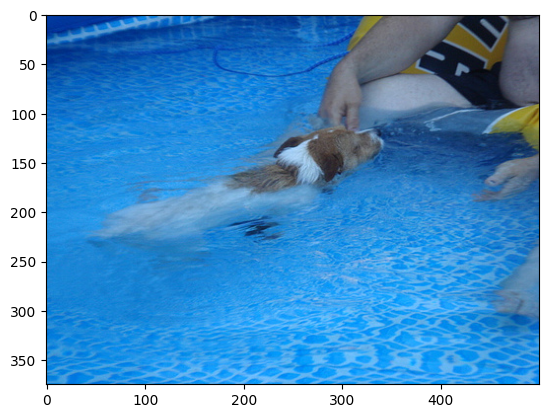

1/1 [==============================] - 0s 30ms/step
Predicted Caption: them front coaches punk fedora charged officials gliders market punk fedora urge officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials officials

Actual Captions
 brown and white dog swimming towards some in the pool 
 dog in swimming pool swims toward sombody we cannot see 
 dog swims in pool near person 
 small dog is paddling through the water in pool 
 the small brown and white dog is in the pool 


In [ ]:
for i in [1]:
    image1 = test_imgs[i]
    imagepath = os.path.join(img_folder, image1)
    image_1 = Image.open(imagepath)
    plt.imshow(image_1)
    plt.show()
    
    encoded_inp=get_features(img_folder, test_imgs[i], pretrained_model, pretrained_input_size)
    pred = caption_generator(photo=encoded_inp,model=loaded_model,max_length=train_max_len,wordtoix=wordtoix,ixtoword=ixtoword )
    
    print(f"Predicted Caption: {' '.join(pred[1:-1])}")

    print('\nActual Captions')
    for capt in desc_dict[test_imgs[i].split('.')[0]]:
      print(capt.replace('startseq','').replace('endseq',''))

    # BLEU Score
    act_cap = [actual_captions[i]]
    findBleuScore([pred],act_cap)